In [1]:
import numpy as np
from numpy import array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model, Model, save_model
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv3D, Conv2D, Conv1D, Dropout, MaxPooling2D, LeakyReLU, BatchNormalization, Reshape, InputLayer, Input, ZeroPadding3D, ZeroPadding2D, UpSampling2D, UpSampling3D, MaxPool3D, MaxPooling3D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from matplotlib import pyplot
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
import sys

NUM_FRAMES = 10
RESOLUTION = 32
CHANNELS = 1

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}

In [2]:
# Display animation
def display_original_animation(dataset, label=''):             
    fig, axes = plt.subplots(1, NUM_FRAMES, figsize=(25, 5))
    ax = axes.flat
    for i, data in enumerate(dataset[:NUM_FRAMES]):                
        ax[i].imshow(dataset[i], cmap='gray', vmin=0., vmax=1.)        
        ax[i].set_title(f"{label} {i}", fontsize=32)
        ax[i].axis("off")      
    plt.show()

In [3]:
def display_triad(triad):
    # Construct a figure for the original and new frames.
    fig, axes = plt.subplots(1, 3, figsize=(20, 4))

    # Plot the original frames.
    for idx, ax in enumerate(axes):
        ax.imshow(np.squeeze(triad[0][idx]), cmap="gray")
        ax.set_title(f"OG {idx}")
        ax.axis("off")
    plt.show()

In [4]:
def create_predict_triad(start_frame, end_frame):
    frames = np.zeros((1, 3, 32, 32, 1))
    frames[0][0] = start_frame
    frames[0][1] = 1
    frames[0][2] = end_frame
    return frames

In [5]:
def predict_animations(real_first_frame, real_last_frame):    
    x = np.zeros((NUM_FRAMES, 32, 32, 1))    
    x[0] = real_first_frame
    x[len(x)-1] = real_last_frame
    array = predict_recursively(x, 0, len(x)-1)
    print(array.shape)
    return array

def predict_recursively(array, pos_start, pos_end):       
    pos_middle = pos_end-((pos_end-pos_start)//2)
    #print(pos_middle)
    if not np.all(array[pos_middle] == 0):
        #print(f"Already predicted: {pos_middle}")
        return array
    
    if (pos_end - pos_start ) <= 1:
        #print("End")
        return array
        
    new_icon_triad = create_predict_triad(array[pos_start], array[pos_end])    
    new_predicted_triad = model.predict(new_icon_triad)
    new_predicted_triad[0][0] = array[0]
    new_predicted_triad[0][2] = array[len(array)-1]    
    """
    check_triad = new_predicted_triad[0][1]
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    axes.imshow(check_triad, cmap='gray')    
    plt.show()
    """
    #print(f"start: {pos_start}, mid: {pos_middle}, end: {pos_end}")
    array[pos_middle] = new_predicted_triad[0][1]
    if pos_middle == NUM_FRAMES // 2:
        print(f"{pos_start} {pos_middle}")
        
    go_left = predict_recursively(array, pos_start, pos_middle)
    go_right = predict_recursively(array, pos_middle, pos_end)
    return np.max([go_left, go_right],axis=0)

In [6]:
checkpoint_filepath = './savedModels/01_CNN_Recursive_v07_noAug.h5'

In [7]:
"""Epoch 18/500
1250/1250 [==============================] - 328s 263ms/step - loss: 0.0055 - accuracy: 0.9300 - val_loss: 0.0055 - val_accuracy: 0.9298 - lr: 1.0000e-08
--- 5876.789655208588 seconds ---"""
model = tf.keras.models.load_model(checkpoint_filepath)

In [8]:
# Clamp images, else the predictions get very blurry
# theta: threshold to decide where to clip values
# epsilon: keep some values unclipped, to avoid too jagged edges
def clamp_image_array(y_hat, theta=.3, epsilon=.1):        
    y_hat_p = np.where(y_hat < theta - epsilon, 0, y_hat)
    y_hat_p = np.where(y_hat_p >= theta + epsilon, 1, y_hat_p)
    return y_hat_p

(64, 64, 4)


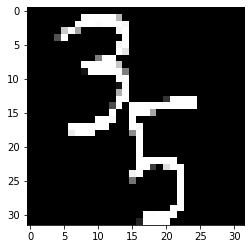

In [9]:
start_raster_graphic = plt.imread('/home/vossi/Documents/Master_Thesis/custom_digits/35_start_inv_thicker.png')
end_raster_graphic = plt.imread('/home/vossi/Documents/Master_Thesis/custom_digits/35_end_inv_thicker.png')
start_frame = np.array(start_raster_graphic)
end_frame = np.array(end_raster_graphic)
print(start_frame.shape)
start_frame = start_frame[::2, ::2, :1]  
end_frame = end_frame[::2, ::2, :1]  

plt.imshow(start_frame, cmap='gray')

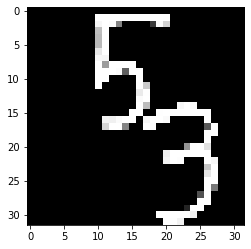

In [10]:
plt.imshow(end_frame, cmap='gray')

0 5
(10, 32, 32, 1)


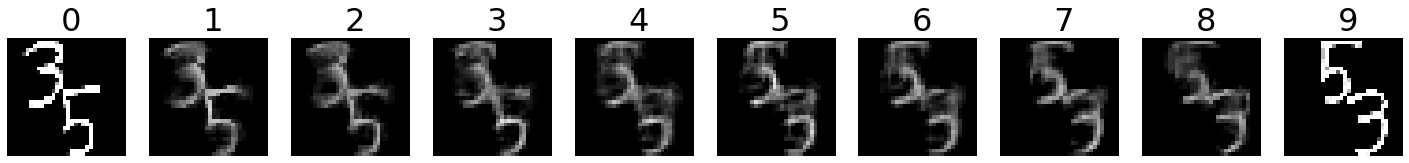

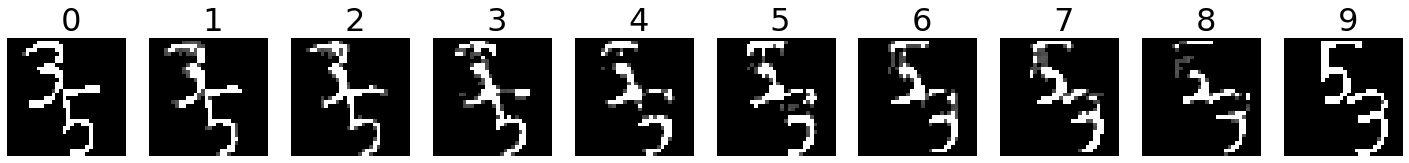

In [19]:
y_hat = predict_animations(start_frame, end_frame)

display_original_animation(y_hat)
display_original_animation(clamp_image_array(y_hat, theta=.3, epsilon=0.05))